In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [2]:
class JapaneseVowelDataset(Dataset):
    def __init__(self, x_path, y_path):
        self.data = np.load(x_path, allow_pickle=True)
        self.labels = np.load(y_path)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

def collate_fn(batch):
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences])
    padded = pad_sequence(sequences, batch_first=True)
    return padded, lengths, torch.tensor(labels)


In [3]:
## Model Definition

class RNNClassifier(nn.Module):
    def __init__(self, input_dim=12, hidden_dim=64, num_layers=1, num_classes=9):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=num_layers,
                          bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x, lengths):
        lengths = lengths.cpu()
        packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_out, h_n = self.rnn(packed)
        h_forward = h_n[-2]
        h_backward = h_n[-1]
        return self.fc(torch.cat((h_forward, h_backward), dim=1))

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=12, hidden_dim=64, num_layers=1, num_classes=9):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x, lengths):
        lengths = lengths.cpu()
        packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_out, (h_n, _) = self.lstm(packed)
        h_forward = h_n[-2]
        h_backward = h_n[-1]
        return self.fc(torch.cat((h_forward, h_backward), dim=1))

class GRUClassifier(nn.Module):
    def __init__(self, input_dim=12, hidden_dim=64, num_layers=1, num_classes=9):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers,
                          bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x, lengths):
        lengths = lengths.cpu()
        packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_out, h_n = self.gru(packed)
        h_forward = h_n[-2]
        h_backward = h_n[-1]
        return self.fc(torch.cat((h_forward, h_backward), dim=1))

class ESNClassifier(nn.Module):
    def __init__(self, input_dim=12, reservoir_size=1000, num_classes=9, spectral_radius=0.95, leaking_rate=0.15):
        super().__init__()
        self.reservoir_size = reservoir_size
        self.leaking_rate = leaking_rate

        self.input_weights = nn.Parameter(
            torch.randn(input_dim, reservoir_size) * 0.1,
            requires_grad=True
        )

        W = torch.randn(reservoir_size, reservoir_size) / (reservoir_size ** 0.5)
        eigvals = torch.linalg.eigvals(W).abs()
        max_eig = eigvals.max().item()
        W = (W / max_eig) * spectral_radius
        self.reservoir_weights = nn.Parameter(W, requires_grad=False)

        self.readout = nn.Linear(reservoir_size, num_classes)

    def forward(self, x, lengths):
        batch_size, seq_len, _ = x.shape
        device = x.device

        states = torch.zeros(batch_size, self.reservoir_size, device=device)
        all_states = []

        for t in range(seq_len):
            u = x[:, t, :]
            preact = u @ self.input_weights + states @ self.reservoir_weights
            new_state = torch.tanh(preact)
            states = (1 - self.leaking_rate) * states + self.leaking_rate * new_state
            all_states.append(states.unsqueeze(1))

        all_states = torch.cat(all_states, dim=1)
        pooled = all_states[torch.arange(batch_size), lengths - 1]
        return self.readout(pooled)



In [4]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for x, lengths, y in loader:
        x, y = x.to(device), y.to(device)
        lengths = lengths.cpu()
        out = model(x, lengths)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, lengths, y in loader:
            x, y = x.to(device), y.to(device)
            lengths = lengths.cpu()
            out = model(x, lengths)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            correct += (preds == y).sum().item()
            total += len(y)
    return correct / total, all_preds, all_labels


In [5]:
def run_experiment(ModelClass, name, train_loader, test_loader, device, epochs=50):
    model = ModelClass().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    train_losses, test_accs = [], []

    for epoch in range(epochs):
        loss = train(model, train_loader, optimizer, criterion, device)
        acc, _, _ = evaluate(model, test_loader, device)
        train_losses.append(loss)
        test_accs.append(acc)
        print(f"[{name}] Epoch {epoch+1:02d} | Loss: {loss:.4f} | Acc: {acc:.2%}")

    _, preds, labels = evaluate(model, test_loader, device)
    return train_losses, test_accs, preds, labels


In [6]:
## Model Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_path = "japanese_vowels_official"
train_dataset = JapaneseVowelDataset(f"{base_path}/X_train.npy", f"{base_path}/y_train.npy")
test_dataset = JapaneseVowelDataset(f"{base_path}/X_test.npy", f"{base_path}/y_test.npy")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

results = {}
for ModelClass in [RNNClassifier, LSTMClassifier, GRUClassifier,ESNClassifier]:
    name = ModelClass.__name__.replace("Classifier", "")
    losses, accs, preds, labels = run_experiment(ModelClass, name, train_loader, test_loader, device)
    results[name] = {"loss": losses, "acc": accs, "preds": preds, "labels": labels}


[RNN] Epoch 01 | Loss: 2.1752 | Acc: 33.51%
[RNN] Epoch 02 | Loss: 2.0484 | Acc: 67.57%
[RNN] Epoch 03 | Loss: 1.7840 | Acc: 47.30%
[RNN] Epoch 04 | Loss: 1.4730 | Acc: 51.62%
[RNN] Epoch 05 | Loss: 1.2813 | Acc: 69.19%
[RNN] Epoch 06 | Loss: 1.1159 | Acc: 70.00%
[RNN] Epoch 07 | Loss: 0.9980 | Acc: 70.00%
[RNN] Epoch 08 | Loss: 0.9067 | Acc: 69.73%
[RNN] Epoch 09 | Loss: 0.8261 | Acc: 73.24%
[RNN] Epoch 10 | Loss: 0.8100 | Acc: 81.35%
[RNN] Epoch 11 | Loss: 0.7106 | Acc: 74.86%
[RNN] Epoch 12 | Loss: 0.7129 | Acc: 78.92%
[RNN] Epoch 13 | Loss: 0.6401 | Acc: 87.03%
[RNN] Epoch 14 | Loss: 0.5590 | Acc: 88.92%
[RNN] Epoch 15 | Loss: 0.5330 | Acc: 87.84%
[RNN] Epoch 16 | Loss: 0.4758 | Acc: 87.84%
[RNN] Epoch 17 | Loss: 0.4899 | Acc: 89.46%
[RNN] Epoch 18 | Loss: 0.5030 | Acc: 81.89%
[RNN] Epoch 19 | Loss: 0.5550 | Acc: 87.03%
[RNN] Epoch 20 | Loss: 0.4431 | Acc: 89.19%
[RNN] Epoch 21 | Loss: 0.3897 | Acc: 90.81%
[RNN] Epoch 22 | Loss: 0.3365 | Acc: 91.08%
[RNN] Epoch 23 | Loss: 0.3117 | 

[ESN] Epoch 37 | Loss: 0.0860 | Acc: 97.03%
[ESN] Epoch 38 | Loss: 0.0835 | Acc: 96.76%
[ESN] Epoch 39 | Loss: 0.0821 | Acc: 96.76%
[ESN] Epoch 40 | Loss: 0.0762 | Acc: 97.03%
[ESN] Epoch 41 | Loss: 0.0748 | Acc: 97.03%
[ESN] Epoch 42 | Loss: 0.0724 | Acc: 96.76%
[ESN] Epoch 43 | Loss: 0.0707 | Acc: 96.76%
[ESN] Epoch 44 | Loss: 0.0666 | Acc: 96.76%
[ESN] Epoch 45 | Loss: 0.0655 | Acc: 97.03%
[ESN] Epoch 46 | Loss: 0.0689 | Acc: 96.76%
[ESN] Epoch 47 | Loss: 0.0660 | Acc: 96.76%
[ESN] Epoch 48 | Loss: 0.0612 | Acc: 97.03%
[ESN] Epoch 49 | Loss: 0.0593 | Acc: 96.76%
[ESN] Epoch 50 | Loss: 0.0628 | Acc: 96.76%


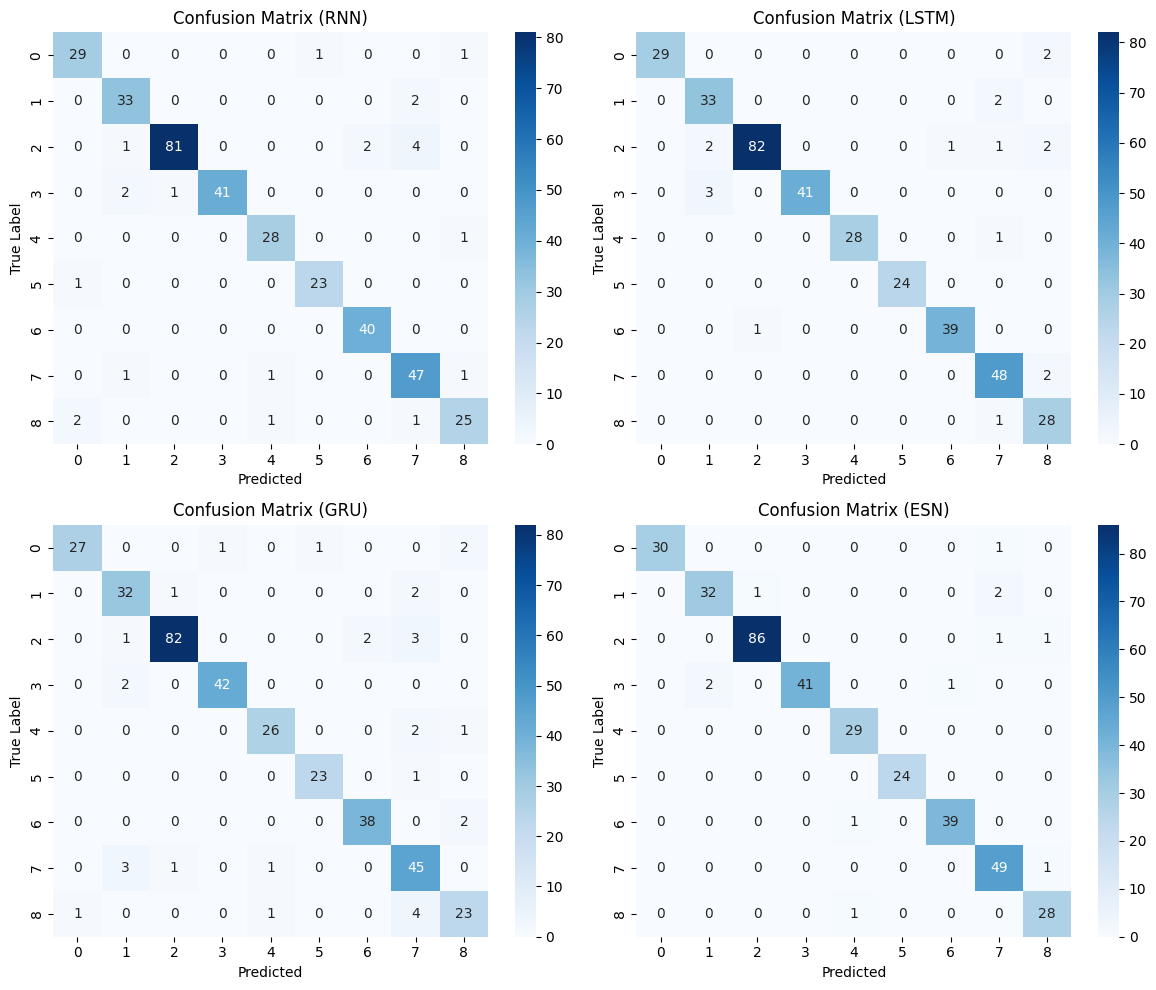

In [7]:
## Confusion Matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, name in enumerate(results):
    cm = confusion_matrix(results[name]['labels'], results[name]['preds'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f"Confusion Matrix ({name})")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True Label")

plt.tight_layout()
plt.show()


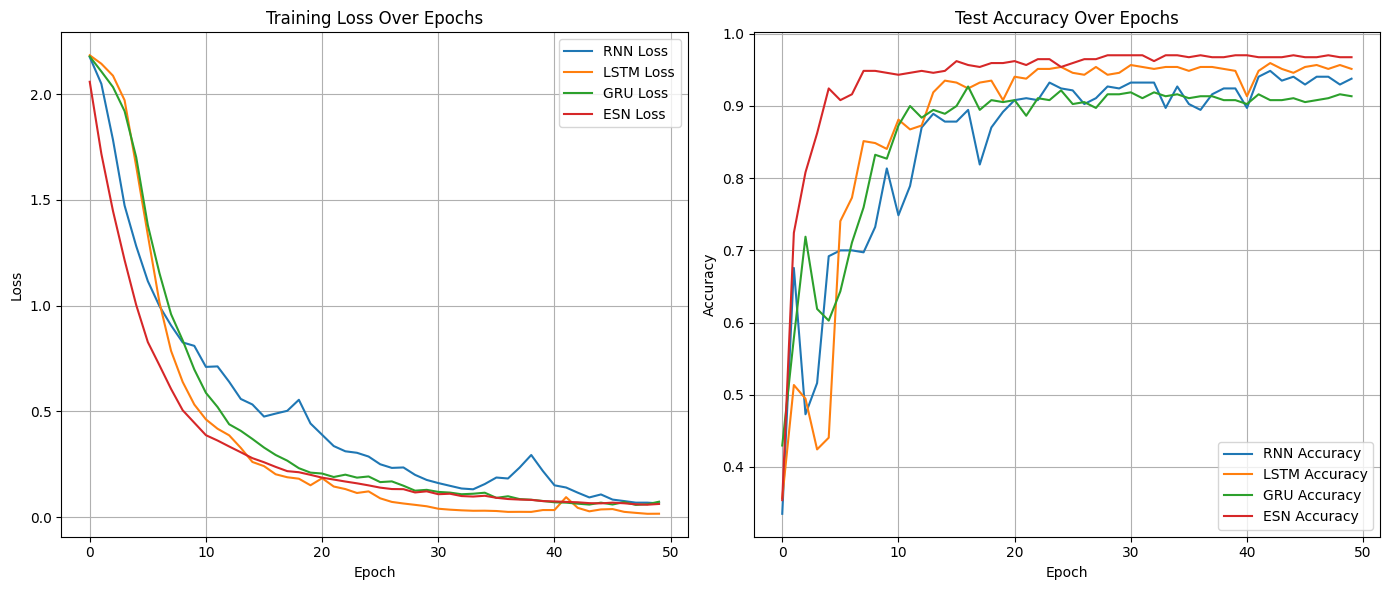

In [8]:
# Loss and accuracy plot
plt.figure(figsize=(14, 6))

# Loss 
plt.subplot(1, 2, 1)
for name in results:
    plt.plot(results[name]['loss'], label=f"{name} Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)

# Accuracy 
plt.subplot(1, 2, 2)
for name in results:
    plt.plot(results[name]['acc'], label=f"{name} Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Over Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
